# DATA512 A1: Data Curation

How does English Wikipedia page traffic trend over time? To answer this question, we plot Wikimedia traffic data spanning from 1 January, 2008 to 30 September 2018. We combine data from two Wikimedia APIs, each covering a different period of time, so that we can show the trend over 10 years.

The first API is [Legacy Pagecounts](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts), with aggregated data from January 2008 to July 2016. The second API is [Pageviews](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), with aggregated data starting from May 2015. Besides the difference in periods for which data is available, there is a quality difference between the two APIs: Pagecounts did not differentiate between traffic generated by a person or by automated robots and web crawlers. The new Pageviews API does make this differentiation and lets us count traffic from agents not identified as web spiders.

The data acquired from both these two API endpoints were available in the public domain under the CC0 1.0 license, according to Wikimedia's [RESTBase](https://wikimedia.org/api/rest_v1/) documentation. Use of these APIs are subject to [terms and conditions from Wikimedia](https://www.mediawiki.org/wiki/REST_API#Terms_and_conditions).

## Data dictionary
Cleaned data from the Wikimedia API are saved to `en-wikipedia_traffic_200712-201809.csv` with the following fields:

| Column Name             | Description                 | Format  |
|-------------------------|-----------------------------|---------|
| year                    | 4-digit year of the period  | YYYY    |
| month                   | 2-digit month of the period | MM      |
| pagecount_all_views     | Number of desktop views     | integer |
| pagecount_desktop_views | Number of desktop views     | integer |
| pagecount_mobile_views  | Number of desktop views     | integer |
| pageview_all_views      | Number of desktop views     | integer |
| pageview_desktop_views  | Number of desktop views     | integer |
| pageview_mobile_views   | Number of desktop views     | integer |


## Data acquisition
In this section, we download data from the Wikimedia APIs and save the raw response JSON object to the raw data folder.

In [1]:
import os, errno
import json
import requests

# API rules require setting a unique User-Agent or Api-User-Agent
# that makes it easy for the API caller to be contacted.
HEADERS = {
    'Api-User-Agent': 'https://github.com/EdmundTse/data-512-a1'
}

def api_call(endpoint, parameters):
    """Makes an web request to the supplied Wikimedia API endpoint."""
    call = requests.get(endpoint.format(**parameters), headers=HEADERS)
    response = call.json()
    return response

In [2]:
# Create the raw data folder, if it doesn't already exist.
# https://stackoverflow.com/questions/273192/

RAW_DATA_DIR = "data_raw"

try:
    os.makedirs(RAW_DATA_DIR)
    print("Created a folder named '%s'." % RAW_DATA_DIR)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

Created a folder named 'data_raw'.


First, collect data from the legacy API for all of the months where data is available. The API call requests data for the entire period of interest, and the API should return the months where data is available.

In [3]:
ENDPOINT_LEGACY = 'https://wikimedia.org/api/rest_v1/metrics/legacy/' + \
    'pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

access_types = ["all-sites", "desktop-site", "mobile-site"]
pagecounts_data_files = []

for access in access_types:
    filename = 'pagecounts_%s_200801-201809.json' % access
    path = os.path.join(RAW_DATA_DIR, filename)
    pagecounts_data_files.append(path)
    
    # Don't re-download if we already have the data.
    if os.path.exists(path):
        print("Skipped download of pagecounts '%s' data since %s already exists." % (access, filename))
        continue
    
    params = {
        "project": "en.wikipedia",
        "access-site": access,
        "granularity": "monthly",
        "start": "2008010100",
        # In monthly granularity, the value is exclusive. So we use
        # the first day of the month after the final month of data
        "end": "2018100100"
    }

    pageviews = api_call(ENDPOINT_LEGACY, params)
    
    with open(path, 'w') as f:
        json.dump(pageviews, f)
        print("Pagecounts '%s' data saved to %s." % (access, filename))

Pagecounts 'all-sites' data saved to pagecounts_all-sites_200801-201809.json.
Pagecounts 'desktop-site' data saved to pagecounts_desktop-site_200801-201809.json.
Pagecounts 'mobile-site' data saved to pagecounts_mobile-site_200801-201809.json.


Similarly, collect data from the new pagecounts API for all of the months where data is available.

In [4]:
ENDPOINT_PAGEVIEWS = 'https://wikimedia.org/api/rest_v1/metrics/' + \
    'pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

access_types = ["all-access", "desktop", "mobile-app", "mobile-web"]
pageviews_data_files = []

for access in access_types:
    filename = 'pageviews_%s_200801-201809.json' % access
    path = os.path.join(RAW_DATA_DIR, filename)
    pageviews_data_files.append(path)
    
    # Don't re-download if we already have the data.
    if os.path.exists(path):
        print("Skipping download of pageviews '%s' data since %s already exists." % (access, filename))
        continue
    
    params = {
        "project": "en.wikipedia",
        "access": access,
        "agent": "user", # Ignore traffic generated by spiders
        "granularity": "monthly",
        "start": "2008010100",
        # Unlike the legacy API, the end value here value is exclusive.
        # So we use the last day of the month of data we need
        "end": "2018093000"
    }

    pageviews = api_call(ENDPOINT_PAGEVIEWS, params)
    
    with open(path, 'w') as f:
        json.dump(pageviews, f)
        print("Pageviews '%s' data downloaded to %s." % (access, filename))

Pageviews 'all-access' data downloaded to pageviews_all-access_200801-201809.json.
Pageviews 'desktop' data downloaded to pageviews_desktop_200801-201809.json.
Pageviews 'mobile-app' data downloaded to pageviews_mobile-app_200801-201809.json.
Pageviews 'mobile-web' data downloaded to pageviews_mobile-web_200801-201809.json.


## Data processing
In this step, we combine the data from both APIs

In [5]:
import pandas as pd
from pandas.io.json import json_normalize

# Create the cleaned data folder, if it doesn't already exist.

CLEAN_DATA_DIR = "data_clean"

try:
    os.makedirs(CLEAN_DATA_DIR)
    print("Created a folder named '%s'." % CLEAN_DATA_DIR)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

Created a folder named 'data_clean'.


First, process the data from the legacy pagecounts API.

In [6]:
# Read and combine all of the downloaded pagecounts data into one dataframe
dataframes = []

for file in pagecounts_data_files:
    with open(file) as f:
        data = json.load(f)
        
    df = json_normalize(data, record_path="items")
    dataframes.append(df)

# Concatenate the dataframes and adapt to the desired format
df_pagecounts = pd.concat(dataframes)
df_pagecounts.loc[:, "source"] = df_pagecounts['access-site'] \
    .replace({
        "all-sites": "pagecount_all_views",
        "desktop-site": "pagecount_desktop_views",
        "mobile-site": "pagecount_mobile_views"
    })
df_pagecounts.loc[:, 'date'] = pd.to_datetime(df_pagecounts.timestamp, format='%Y%m%d00')
df_pagecounts = df_pagecounts.drop(['access-site', 'granularity', 'project', 'timestamp'], axis=1)
df_pagecounts = df_pagecounts.rename(index=str, columns={'count': 'views'})
df_pagecounts.tail()

,views,source,date
18,3301385124,pagecount_mobile_views,2016-04-01
19,3418435805,pagecount_mobile_views,2016-05-01
20,3372618063,pagecount_mobile_views,2016-06-01
21,3500661121,pagecount_mobile_views,2016-07-01
22,480041296,pagecount_mobile_views,2016-08-01


We see that there is an entry for the month of August 2016, and it is about an order of magnitude smaller than previous months. The API documentation states that data will never be updated after July 2016, so the value we see for August 2016 might be from the first few days of the month while the data processing is being shut down. For our purposes, we will remove all entries after July 2016.

In [7]:
df_pagecounts = df_pagecounts[df_pagecounts.date < pd.datetime(2016, 8, 1)]

Now, process the data from the pageviews API. This API not only allows us to request only organic user traffic, it also splits mobile views into mobile app and mobile web. We shall add these two values together to produce one mobile views number.

In [8]:
# Read and combine all of the downloaded pageviews data into one dataframe
dataframes = []

for file in pageviews_data_files:
    with open(file) as f:
        data = json.load(f)
        
    df = json_normalize(data, record_path="items")
    dataframes.append(df)

# Concatenate the dataframes and adapt to the desired format
df_pageviews = pd.concat(dataframes)
df_pageviews.loc[:, "source"] = df_pageviews['access'] \
    .replace({
        "all-access": "pageview_all_views",
        "desktop": "pageview_desktop_views",
        "mobile-app": "pageview_mobile_views", # Combine mobile-app and mobile-web
        "mobile-web": "pageview_mobile_views"  # views into mobile views
    })
df_pageviews.loc[:, 'date'] = pd.to_datetime(df_pageviews.timestamp, format='%Y%m%d00')
df_pageviews = df_pageviews.drop(['access', 'agent', 'granularity', 'project', 'timestamp'], axis=1)

df_pageviews.head()

,views,source,date
0,7665421980,pageview_all_views,2015-07-01
1,7634815221,pageview_all_views,2015-08-01
2,7655695037,pageview_all_views,2015-09-01
3,7746031887,pageview_all_views,2015-10-01
4,7524321290,pageview_all_views,2015-11-01


With the data from both APIs in tables with common columns, we can now concatenate them before using a pivot table reshape it into the required format for outputting to CSV. With a pivot table, we specify that values for the same month and source are combined by taking the sum over the values. This is needed for pageview_mobile_views since we converted both mobile-app and mobile-web access types into the same 'mobile' type.

In [9]:
df = pd.concat([df_pagecounts, df_pageviews], sort=False)
new_index = pd.DatetimeIndex(df.date).to_period(freq='M')
df = df.pivot_table(values='views', index=new_index, columns='source', aggfunc='sum', fill_value=0)
df.loc[:, 'year'] = df.index.year
df.loc[:, 'month'] = df.index.month
df.head()

source,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,year,month
date,,,,,,,,
2008-01,4930902570,4930902570,0,0,0,0,2008,1
2008-02,4818393763,4818393763,0,0,0,0,2008,2
2008-03,4955405809,4955405809,0,0,0,0,2008,3
2008-04,5159162183,5159162183,0,0,0,0,2008,4
2008-05,5584691092,5584691092,0,0,0,0,2008,5


In [10]:
# Output the cleaned data in the required format
CLEANED_FILENAME = 'en-wikipedia_traffic_200712-201809.csv'
cleaned_filepath = os.path.join(CLEAN_DATA_DIR, CLEANED_FILENAME)

OUTPUT_COLUMNS = [
    'year',
    'month',
    'pagecount_all_views',
    'pagecount_desktop_views',
    'pagecount_mobile_views',
    'pageview_all_views',
    'pageview_desktop_views',
    'pageview_mobile_views'
]

df.to_csv(cleaned_filepath, columns=OUTPUT_COLUMNS, index=False)

## Analysis

To understand how the English Wikipedia page traffic trends over time, we will plot each of the series of data from old and new API as well as for mobile, desktop and the total traffic (mobile plus desktop). Because the pageviews count ranges into the billions, we divide the counts by 1 million to make the numbers shown on the y-axis more readable.

In [11]:
# Create the results data folder, if it doesn't already exist.

RESULTS_DIR = "results"

try:
    os.makedirs(RESULTS_DIR)
    print("Created a folder named '%s'." % RESULTS_DIR)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

Created a folder named 'results'.


In [12]:
# Re-create the pivot table, without filling NA values with zeros, for a cleaner plot
df = pd.concat([df_pagecounts, df_pageviews], sort=False)
df = df.pivot_table(values='views', index=new_index, columns='source', aggfunc='sum')

# Rescale the values into "millions of views" for easier to read numbers
df = df / 1e6

df.head()

source,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
date,,,,,,
2008-01,4930.902570,4930.902570,NaN,NaN,NaN,NaN
2008-02,4818.393763,4818.393763,NaN,NaN,NaN,NaN
2008-03,4955.405809,4955.405809,NaN,NaN,NaN,NaN
2008-04,5159.162183,5159.162183,NaN,NaN,NaN,NaN
2008-05,5584.691092,5584.691092,NaN,NaN,NaN,NaN


(0, 11162.54169905)

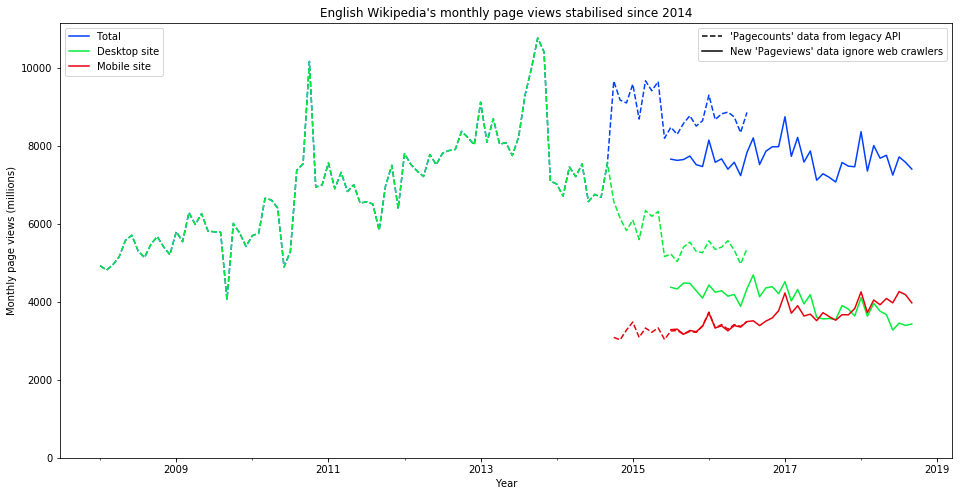

In [13]:
%matplotlib inline

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.style.use('seaborn-bright')

pagecount_series = ['pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views']
pageview_series = ['pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']

fig, ax = plt.subplots(figsize=(16,8))
df.loc[:, pageview_series].plot(ax=ax, style='-')
ax.set_prop_cycle(None) # Reset colour cycling
df.loc[:, pagecount_series].plot(ax=ax, style='--')

linestyle_legend = [mlines.Line2D([], [], color='k', linestyle='--', label="'Pagecounts' data from legacy API"),
                    mlines.Line2D([], [], color='k', linestyle='-', label="New 'Pageviews' data ignore web crawlers")]
ax.add_artist(ax.legend(handles=linestyle_legend))

ax.legend(["Total", "Desktop site", "Mobile site"], loc=2)

ax.set_title("English Wikipedia's monthly page views stabilised since 2014")
ax.set_xlabel("Year")
ax.set_ylabel("Monthly page views (millions)")
ax.set_ylim((0, None)) # Make the value axis for page views start from 0

In [14]:
# Save the plot to file
PLOT_FILENAME = 'en-wikipedia_traffic_200712-201809.png'
plot_filepath = os.path.join(RESULTS_DIR, PLOT_FILENAME)
fig.savefig(plot_filepath)

## Findings
From the plot, we can see that page traffic for English Wikipedia steadily rose from 2008 until about 2014, when the page traffic became stable at around 8 billion views per month.

Before mid-2014, Wikimedia only reported one desktop pagecounts number. Since then it separated page views into desktop and mobile, when it also started to report a total value for the combination of the two.

The total pageviews using the new Pageviews API reported substantially fewer views than the legacy API. Comparing the two lines during the overlapping period, it appears roughly one tenth of all traffic was due to web crawlers.